In [1]:
import random

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')
from tqdm.auto import trange

from src.rlmcmc.env import RLMHEnvV301a1
from src.rlmcmc.utils import Args, Toolbox

In [2]:
log_p = lambda x: norm.logpdf(x, 0, 1)[0]

In [3]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x


In [4]:
class Actor(nn.Module):
    def __init__(self, envs, device: torch.device = torch.device("cpu")) -> None:
        super().__init__()
        self.device = device

        self.sample_dim = int(np.array(envs.single_observation_space.shape).prod()) >> 1

        self.fc1 = nn.Linear(self.sample_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc_mu = nn.Linear(8, self.sample_dim)

    def forward(self, observation: torch.Tensor) -> torch.Tensor:
        "Mu function"
        current_sample, proposed_sample = torch.split(
            observation, [self.sample_dim, self.sample_dim], dim=1
        )

        return torch.hstack(
            [self.magnification(current_sample), self.magnification(proposed_sample)]
        )

    def magnification(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softplus(self.fc_mu(x))
        x = torch.sqrt(torch.square(x))
        return x


In [5]:
# env setup
args = Args()
args.seed = 1234
args.env_id = 'RLMHEnv-v3.0.1.alpha.1'

args.log_target_pdf = log_p
args.sample_dim = 1

args.total_timesteps = 100_000
args.batch_size = 32
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.99
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-5
args.policy_frequency = 2

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
actor = torch.compile(actor)
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf1 = torch.compile(qf1)
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
qf1_target = torch.compile(qf1_target)
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor = torch.compile(target_actor)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)

In [6]:
# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)

qf1_loss_list = []
qf1_values_list = []

In [7]:
for global_step in trange(args.total_timesteps):
    if global_step < args.learning_starts:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        with torch.no_grad():
            actions = actor(torch.from_numpy(obs).to(device))
            # actions += torch.normal(0, torch.ones_like(torch.tensor((envs.action_space.high - envs.action_space.low) / 2.0)))
            actions = actions.cpu().numpy().clip(envs.single_action_space.low, envs.single_action_space.high)

    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    obs = next_obs

    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        with torch.no_grad():
            next_state_actions = target_actor(data.next_observations)
            qf1_next_target = qf1_target(data.next_observations, next_state_actions)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (qf1_next_target).view(-1)
        qf1_a_values = qf1(data.observations, data.actions).view(-1)

        qf1_values_list.append(qf1_a_values)

        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

        qf1_loss_list.append(qf1_loss.item())

        # optimize the model
        q_optimizer.zero_grad()
        qf1_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:
            actor_loss = -qf1(data.observations, actor(data.observations)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # update the target network
            for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)


  0%|          | 0/100000 [00:00<?, ?it/s]

In [8]:
env = envs.unwrapped.envs[0].env.env.env
observation_list = np.array(env.store_observation)

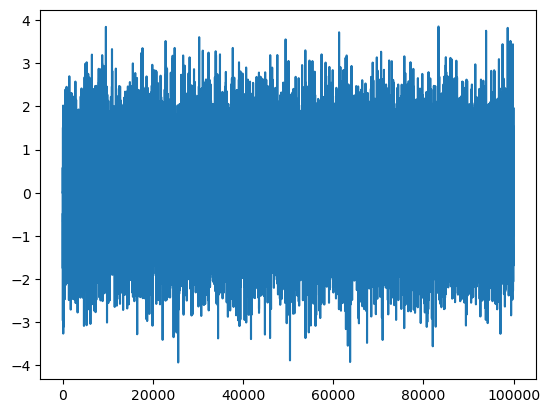

In [9]:
plt.plot(observation_list[:, 0])

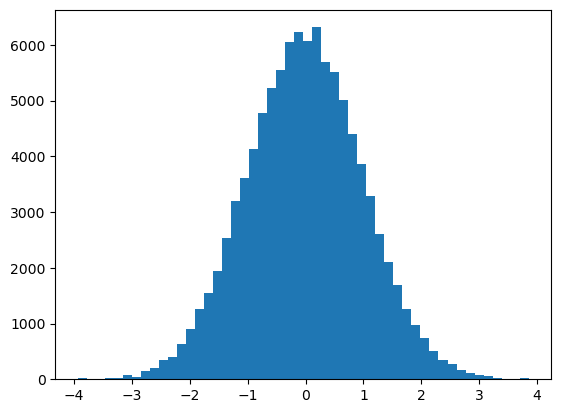

In [10]:
plt.hist(observation_list[args.learning_starts:, 0], bins=50)
plt.show()

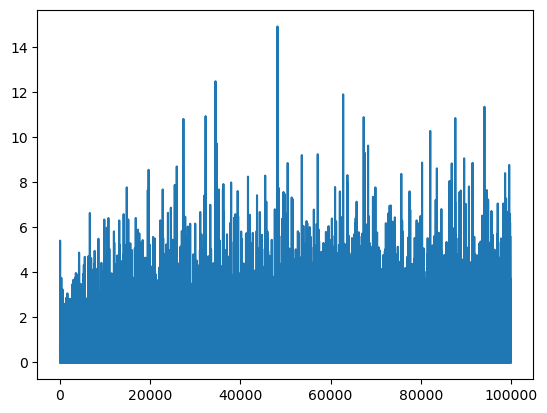

In [11]:
plt.plot(np.array(env.store_reward))
plt.show()

In [12]:
x = np.linspace(-10, 10, 1000).reshape(-1, 1)
x_next = np.zeros_like(x)
observation = np.hstack([x, x_next])
with torch.no_grad():
    actions = actor(torch.from_numpy(observation).to(device))
    # actions = actor.low_rank_vector_and_magnification(torch.as_tensor([[1.0]], dtype=torch.double))
actions_np = actions.cpu().numpy()

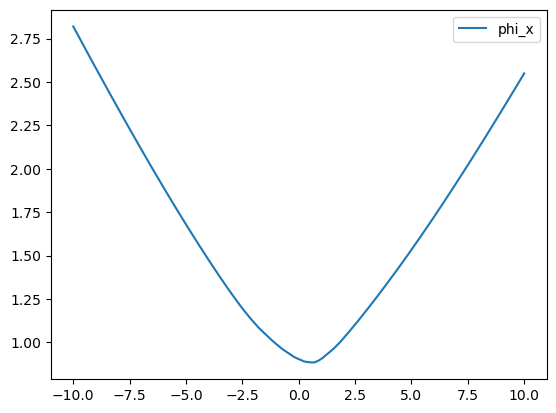

In [13]:
plt.plot(x, actions_np[:, 0], label='phi_x')
# plt.plot(x, actions_np[:, 1], label='phi_sd')
plt.legend()
plt.show()

In [14]:
np.max(actions_np[:, 0])

2.8201616670332026

In [15]:
x_next = np.linspace(-3, 3, 1000).reshape(-1, 1)
x = np.zeros_like(x)
observation_next = np.hstack([x, x_next])
with torch.no_grad():
    actions_next = actor(torch.from_numpy(observation_next).to(device))
    # actions = actor.low_rank_vector_and_magnification(torch.as_tensor([[1.0]], dtype=torch.double))
actions_next_np = actions_next.cpu().numpy()

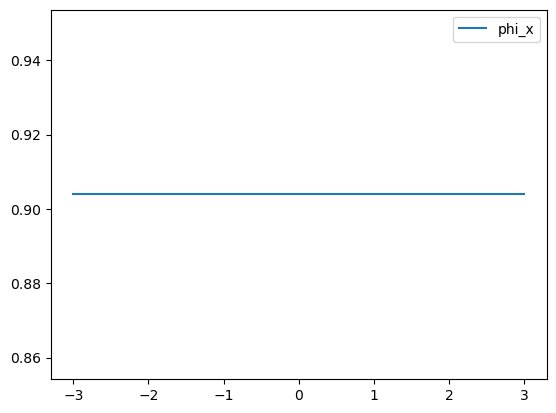

In [16]:
plt.plot(x_next, actions_next_np[:, 0], label='phi_x')
# plt.plot(x_next, actions_next_np[:, 1], label='phi_sd')
plt.legend()
plt.show()

In [17]:
np.sum(env.store_accetped_status) / len(env.store_accetped_status)

0.72078

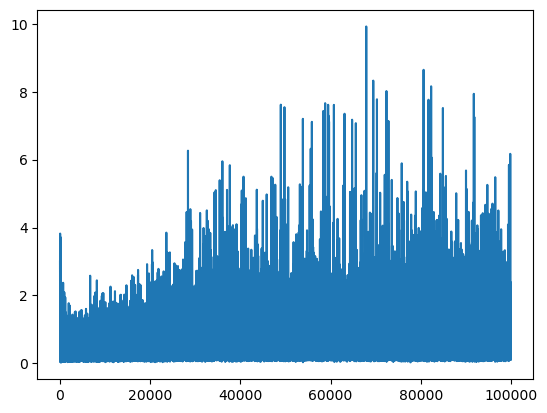

In [18]:
plt.plot(qf1_loss_list)
plt.show()

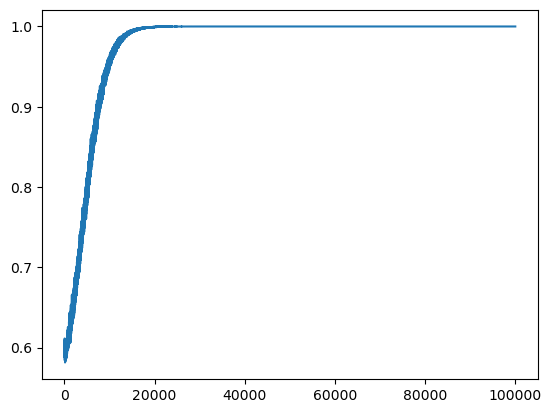

In [19]:
plt.plot(np.array([i.mean().detach().numpy() for i in qf1_values_list]))
plt.show()